In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import timedelta

import pypfopt as pt
from beeprint import pp

In [55]:
#df = pd.read_excel('4_portfolios_sorted_by_size_and_illiquidity_2x2.xls')
df = pd.read_excel('7_portfolios_sorted_by_industry.xls')

In [56]:
df.year = df.year.astype('str')
df.month = df.month.astype('str')
df.day = df.day.astype('str')

In [57]:
df['data'] = df['year']+'-'+df['month']+'-'+df['day']

In [58]:
df['data'] = pd.to_datetime(df['data'])

In [59]:
df.set_index('data',inplace=True)

In [60]:
df.drop(['year','month','day'],axis=1,inplace=True)

In [61]:
col = [
 'Industry_3',
 'Industry_4',
 'Industry_5',
      'Industry_6',
      'Industry_7']

In [62]:
df = df[col]

# Grafico distribuição dos Retornos

<AxesSubplot:xlabel='data'>

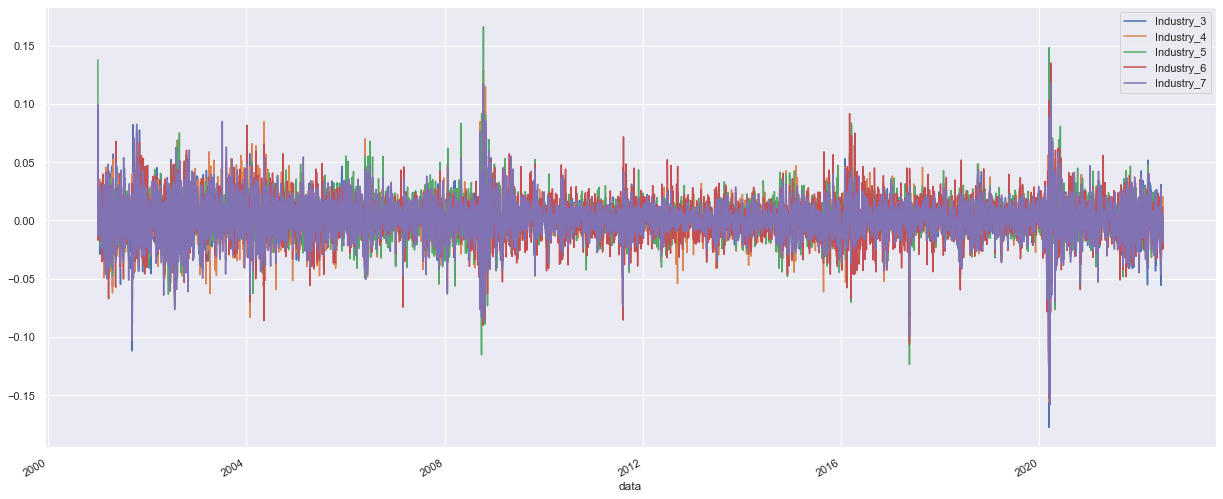

In [63]:
sns.set()
df.plot(figsize=(21,9))


In [64]:
retorno = df

# Retorno Anualizado

In [65]:
retorno_anual = retorno.mean() * 264

In [66]:
retorno

,Industry_3,Industry_4,Industry_5,Industry_6,Industry_7
data,,,,,
2001-01-02,-0.001977,-0.002255,0.137751,0.018988,-0.013664
2001-01-03,0.061688,0.092555,0.023463,0.081931,0.099396
2001-01-04,0.004532,-0.017185,0.008012,0.015833,-0.007965
2001-01-05,-0.012516,0.001496,0.004175,-0.016272,-0.014778
2001-01-08,0.005060,0.011969,0.007369,0.009363,0.004894
...,...,...,...,...,...
2022-06-24,-0.004209,0.004586,-0.001717,0.011468,0.001084
2022-06-27,-0.000056,0.020349,0.002760,0.007564,0.003831
2022-06-28,-0.016104,0.006041,-0.008383,-0.015584,-0.017956


# Retorno Anual

In [67]:
retorno_anual

Industry_3    0.114170
Industry_4    0.193999
Industry_5    0.185117
Industry_6    0.235923
Industry_7    0.150647
dtype: float64

# Matriz de Covariância

In [68]:
cov = retorno.cov() * 264
cov

,Industry_3,Industry_4,Industry_5,Industry_6,Industry_7
Industry_3,0.069833,0.058766,0.058377,0.061235,0.059437
Industry_4,0.058766,0.076008,0.057757,0.060870,0.059263
Industry_5,0.058377,0.057757,0.081192,0.060556,0.059512
Industry_6,0.061235,0.060870,0.060556,0.089889,0.061785
Industry_7,0.059437,0.059263,0.059512,0.061785,0.074170


# Matriz de Correlação

In [69]:
corr = retorno.corr()
corr

,Industry_3,Industry_4,Industry_5,Industry_6,Industry_7
Industry_3,1.000000,0.806620,0.775277,0.772892,0.825872
Industry_4,0.806620,1.000000,0.735223,0.736417,0.789297
Industry_5,0.775277,0.735223,1.000000,0.708838,0.766898
Industry_6,0.772892,0.736417,0.708838,1.000000,0.756691
Industry_7,0.825872,0.789297,0.766898,0.756691,1.000000


In [70]:
num_acoes = len(list(df))
num_carteiras = 1000
peso = np.random.random(num_acoes)
peso /= np.sum(peso)

In [71]:
retorno_esperado = np.dot(peso,retorno_anual)

In [72]:
peso

array([0.34181537, 0.27511476, 0.26936701, 0.07887841, 0.03482446])

In [73]:
retorno_esperado

0.16611683446545725

In [75]:

lista_stats = list()
for i in list(df):
    d = df[i].describe()
    d = d.to_dict()
    d.update({'curtose':df[i].skew(),
              'assimetria':df[i].kurtosis()})
    
    #s = pd.DataFrame(d,index=[i]).T
    lista_stats.append(d)
    
    

rename = {idx:i for idx,i in enumerate(list(df))}

stats = pd.DataFrame(lista_stats).T   
stats.rename(columns=rename, inplace = True)

# Descritiva dos dados das carteiras

In [76]:
stats

,Industry_3,Industry_4,Industry_5,Industry_6,Industry_7
count,5321.000000,5321.000000,5321.000000,5321.000000,5321.000000
mean,0.000432,0.000735,0.000701,0.000894,0.000571
std,0.016264,0.016968,0.017537,0.018452,0.016761
min,-0.177662,-0.155818,-0.147755,-0.154935,-0.158202
25%,-0.007413,-0.007868,-0.008756,-0.009373,-0.007599
50%,0.000722,0.001120,0.000743,0.001109,0.000759
75%,0.008909,0.009528,0.009998,0.011206,0.009106
max,0.132709,0.128969,0.166291,0.135133,0.118100
curtose,-0.622364,-0.305855,-0.003866,-0.339895,-0.467537
assimetria,10.335891,6.706909,8.139468,5.195822,8.154057


In [77]:
#Ultimo dia de cada mês para criação dos periodos

def UltimoDiaMes(data):
    
    #data = datetime.datetime.strptime(data, '%Y-%m-%d')
    
    date = datetime.datetime(data.year,data.month, data.day)
    nxt_mnth = date.replace(day=28) + datetime.timedelta(days=4)        
    res = nxt_mnth - datetime.timedelta(days=nxt_mnth.day)
    
    return res

In [78]:
#Busca Os dias dentro de um range de datas
def RangeDate(inicio, fim):
    data_inicio = datetime.datetime.strptime(inicio, '%Y-%m-%d')
    data_fim = datetime.datetime.strptime(fim, '%Y-%m-%d')

    delta = data_fim - data_inicio

    lista_datas = []
    for i in range(delta.days + 1):
        day = data_inicio + timedelta(days=i)
        lista_datas.append(day)
        
    d_l = pd.DataFrame(lista_datas,columns=['data'])
    lista = list(d_l.data[d_l['data'].dt.day == 1])
    
    return lista

In [79]:
#Carteira ingênua

def pesosPortafolioIngenuo(dataframe):
    array = []
    for i in dataframe.columns:
        array.append(1/len(dataframe.columns))
    arrayFinal = np.array(array)
    return arrayFinal


In [80]:
#Cria o range de datas existente dentro de um periodo de teste, primeiro dia e 
#ultimo de cada mês para que seja usado no periodo de teste
def CriaListaPeriodoTestes(inicio,fim):

    a = RangeDate(inicio,fim)
    lista_datas = list()
    for i in a:
        d = {
            'inicio':i,
            'fim':UltimoDiaMes(i)
        }
        lista_datas.append(d)
    return lista_datas

In [81]:
#Carteira de Minima Variância
def MinVarPesos(retornos, df_cov,restricao):
    ef = pt.EfficientFrontier(retornos, df_cov, weight_bounds=(restricao,1))
    weights = ef.min_volatility() 
    cleaned_weights = ef.clean_weights() 
    #print(cleaned_weights)
    #print('-----------MinVar--------')
    relat = ef.portfolio_performance()
    return relat, cleaned_weights

In [82]:
#Carteira Maior Indice Sharpe
def MaxSharpRatio(retornos, df_cov, restricao):
    ef = pt.EfficientFrontier(retornos, df_cov,weight_bounds=(restricao,1))
    weights = ef.max_sharpe() 
    cleaned_weights = ef.clean_weights() 
    #print(cleaned_weights) 
    #print('------------Tang---------')
    relat = ef.portfolio_performance(verbose=False)
    return relat, cleaned_weights

In [83]:
#Funções Basicas

def Volatilidade(pesos,cov):
    volatilidade = np.sqrt(np.dot(pesos.T, np.dot(cov,pesos)))
    return volatilidade

def RetornoEsperado(pesos,retorno_anual):
    retorno_esperado = np.dot(pesos,retorno_anual)
    return retorno_esperado

def ConvertDictArray(dicionario):
    nova_lista = [dicionario[i] for i in dicionario]
    lista = np.asarray(nova_lista)
    return lista


In [84]:
#Função para formação de carteiras

def Carteiras(df,data_inicio, data_fim):
    if len(data_inicio)>0:
        df = df[(df.index >= data_inicio) & (df.index <= data_fim)]
    
    retorno = df
    retorno_anual = retorno.mean() * 264
    cov = retorno.cov() * 264
    corr = retorno.corr()
    
    pesos = pesosPortafolioIngenuo(df)
    retorno_esperado = RetornoEsperado(pesos,retorno_anual) #np.dot(pesos,retorno_anual)
    
    volatilidade = Volatilidade(pesos,cov) #np.sqrt(np.dot(pesos.T, np.dot(cov,pesos)))
    
    cart_min_var = MinVarPesos(retorno_anual,cov,0)
    cart_tang_var = MaxSharpRatio(retorno_anual,cov,0)
    
    cart_min_var_sr = MinVarPesos(retorno_anual,cov,-1)
    cart_tang_var_sr = MaxSharpRatio(retorno_anual,cov,-1)
    
    
    retorno_pesos = {
        'w>0':{
        'min_var':dict(cart_min_var[1]),
        'tang':dict(cart_tang_var[1])
        },
        'ingenua': {'ingenua':{i: pesos[idx-1] for idx,i in enumerate(list(df))}
                   },
        'sem_restricao':{
        'min_var':dict(cart_min_var_sr[1]),
        'tang':dict(cart_tang_var_sr[1])
        }
        
    }
    
    d = {}
    for i in retorno_pesos:
        new = {
            i:{}
        }
        d.update(new)
        
        for m in retorno_pesos[i]:
            level1 = retorno_pesos[i][m]
            
            ListaPesos = ConvertDictArray(level1)
            vol = Volatilidade(ListaPesos,cov)
            ret_esp = RetornoEsperado(ListaPesos,retorno_anual)
            
            r = { m:{
                'volatilidade':vol,
                'retorno_esperado': ret_esp,
                'sharp':ret_esp/vol,
                'pesos':ListaPesos
                
                }
            }
            
            d[i].update(r)
    
    return d

In [85]:
#Criar Retorno para periodo expecifico

def RetornoPeriodoForaAmostra(df,data_inicio, data_fim, pesos):
    
    df = df[(df.index >= data_inicio) & (df.index <= data_fim)]
    
    pesos = np.asarray(pesos)
    
    retorno = df
    retorno_anual = retorno.mean() * 264
    cov = retorno.cov() * 264
    corr = retorno.corr()
    
    retorno_esperado = RetornoEsperado(pesos,retorno_anual) #np.dot(pesos,retorno_anual)
    
    volatilidade = Volatilidade(pesos,cov) #np.sqrt(np.dot(pesos.T, np.dot(cov,pesos)))
    
    d = {
    'retorno_periodo':retorno_esperado,
    'volatilidade': volatilidade,
    'sharpe': retorno_esperado/volatilidade
        
    }
    
    return d

In [88]:
resultado = {}
print("-------------------------PERIODO AMOSTRA------------------------")
#Amostra Periodo
inicio = '2001-01-01'
fim = '2014-12-31'
ret_pesos = Carteiras(df,inicio, fim)
resultado.update({'amostra':ret_pesos})


-------------------------PERIODO AMOSTRA------------------------


In [173]:
lista_retornos_stats = list()
for i in resultado['amostra']:
    for j in resultado['amostra'][i]:
        #print(pd.DataFrame(resultado['amostra'][i][j]))
        d = {
            'carteira': str(i)+' - '+ str(j),
            'volatilidade': resultado['amostra'][i][j]['volatilidade'],
            'retorno_esperado':resultado['amostra'][i][j]['retorno_esperado'],
            'sharpe': resultado['amostra'][i][j]['sharp'],
            'pesos': ', '.join(str(v) for v in list(resultado['amostra'][i][j]['pesos']))
            
        }
        lista_retornos_stats.append(d)
        
        #print(pd.DataFrame(d, index=[0]))
        #break
    #break

# Tabela - Resultado de Carteiras Periodos Amostra

In [211]:
pd.DataFrame(lista_retornos_stats)

,carteira,volatilidade,retorno_esperado,sharpe,pesos
0,w>0 - min_var,0.243772,0.169217,0.694160,"0.38762, 0.09209, 0.17437, 0.10779, 0.23813"
1,w>0 - tang,0.266957,0.229132,0.858312,"0.0, 0.0, 0.32527, 0.67473, 0.0"
2,ingenua - ingenua,0.245565,0.185003,0.753376,"0.2, 0.2, 0.2, 0.2, 0.2"
3,sem_restricao - min_var,0.243772,0.169217,0.694160,"0.38762, 0.09209, 0.17437, 0.10779, 0.23813"
4,sem_restricao - tang,0.333366,0.308383,0.925060,"-1.0, 0.24759, 0.68657, 1.0, 0.06584"


# Calculo periodos Fora da Amostra


In [89]:
print("------------------------Fora Amostra-------------------------------")
inicio_f_amostra = '2015-01-01'
fim_f_amostra = '2022-06-30'
datas = CriaListaPeriodoTestes(inicio_f_amostra,fim_f_amostra)


simulacoes = {}
for ret in resultado['amostra']:
    simulacoes.update({ret:{}})
    for cart in resultado['amostra'][ret]:
        pesos = resultado['amostra'][ret][cart]['pesos']
        simulacoes[ret].update({cart:{}})
        lista_simulacoes = list()
        print('Carteira:')
        for i in datas:
            ret_periodo = RetornoPeriodoForaAmostra(df,i['inicio'],i['fim'],pesos)
            ret_periodo.update(i)
            ret_periodo.update({'pesos_atuais':pesos})
            
            recalc_pesos = Carteiras(df,inicio, i['fim'])
            novos_pesos = recalc_pesos[ret][cart]['pesos']
            
            ret_periodo.update({'novos_pesos':novos_pesos})
            pesos = novos_pesos
            
            lista_simulacoes.append(ret_periodo)
            
        simulacoes[ret][cart].update({'valor':lista_simulacoes})
            #break
            
        #break
    #break

------------------------Fora Amostra-------------------------------
Carteira:
Carteira:
Carteira:
Carteira:
Carteira:


In [90]:
sim_stats = pd.DataFrame()
list_stats_sim = list()
for i in simulacoes.keys():
    for j in simulacoes[i].keys():
    
        v = str(i)+'-'+str(j)
        sim_stats[v] = pd.DataFrame(simulacoes[i][j]['valor'])['retorno_periodo']

sim_stats.index = pd.DataFrame(simulacoes[i][j]['valor'])['inicio']
#sim_stats['fim'] = pd.DataFrame(simulacoes[i][j]['valor'])['fim']

In [91]:
sim_volatilidade = pd.DataFrame()
for i in simulacoes.keys():
    for j in simulacoes[i].keys():
    
        v = str(i)+'-'+str(j)
        sim_volatilidade[v] = pd.DataFrame(simulacoes[i][j]['valor'])['volatilidade']

sim_volatilidade.index = pd.DataFrame(simulacoes[i][j]['valor'])['inicio']
#sim_stats['fim'] = pd.DataFrame(simulacoes[i][j]['valor'])['fim']

In [92]:
sim_stats_sharpe = pd.DataFrame()
list_stats_sim = list()
for i in simulacoes.keys():
    for j in simulacoes[i].keys():
    
        v = str(i)+'-'+str(j)
        sim_stats_sharpe[v] = pd.DataFrame(simulacoes[i][j]['valor'])['sharpe']

sim_stats_sharpe.index = pd.DataFrame(simulacoes[i][j]['valor'])['inicio']
#sim_stats['fim'] = pd.DataFrame(simulacoes[i][j]['valor'])['fim']

# Resultados para o periodo fora da Amostra
Periodo 2015-01-01 a 2022-06-30

# Grafico de Retornos

<AxesSubplot:xlabel='inicio'>

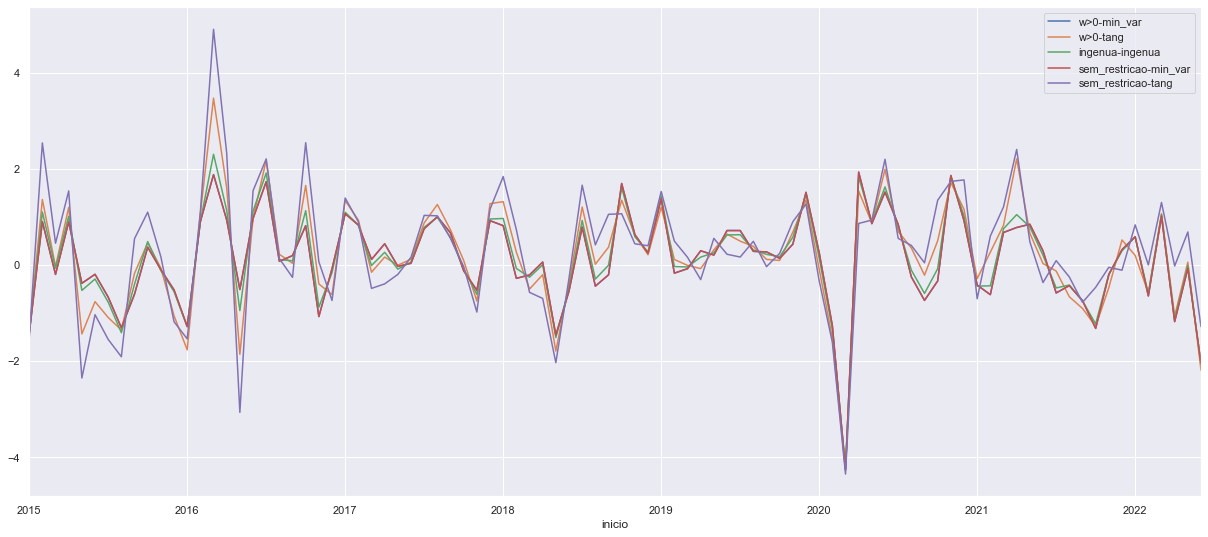

In [93]:
sns.set()
sim_stats.plot(figsize=(21,9))

# Tabela de Retornos
Periodo Fora da Amostra

In [94]:
sim_stats

,w>0-min_var,w>0-tang,ingenua-ingenua,sem_restricao-min_var,sem_restricao-tang
inicio,,,,,
2015-01-01,-1.429854,-1.414820,-1.430314,-1.429854,-1.528122
2015-02-01,0.910055,1.370151,1.110346,0.910055,2.549180
2015-03-01,-0.189900,-0.027711,-0.060331,-0.189900,0.460954
2015-04-01,0.904287,1.206488,1.020576,0.904287,1.549730
2015-05-01,-0.374181,-1.429566,-0.522443,-0.374181,-2.347348
...,...,...,...,...,...
2022-02-01,-0.637829,-0.579183,-0.591358,-0.637829,0.007190
2022-03-01,1.025180,1.075835,1.057276,1.025180,1.310014
2022-04-01,-1.172485,-1.056352,-1.134426,-1.172485,-0.013405


# Tabela de Volatilidade

In [95]:
sim_volatilidade

,w>0-min_var,w>0-tang,ingenua-ingenua,sem_restricao-min_var,sem_restricao-tang
inicio,,,,,
2015-01-01,0.235719,0.286755,0.254134,0.235719,0.386650
2015-02-01,0.166957,0.156660,0.161549,0.166957,0.217352
2015-03-01,0.176281,0.201931,0.188938,0.176281,0.294226
2015-04-01,0.137786,0.161105,0.139166,0.137786,0.231276
2015-05-01,0.141732,0.180189,0.150455,0.141732,0.249913
...,...,...,...,...,...
2022-02-01,0.171683,0.208386,0.167704,0.171683,0.200646
2022-03-01,0.324055,0.308184,0.304565,0.324055,0.309381
2022-04-01,0.202077,0.214377,0.200367,0.202077,0.189752


# Grafico de Volatilidade

<AxesSubplot:xlabel='inicio'>

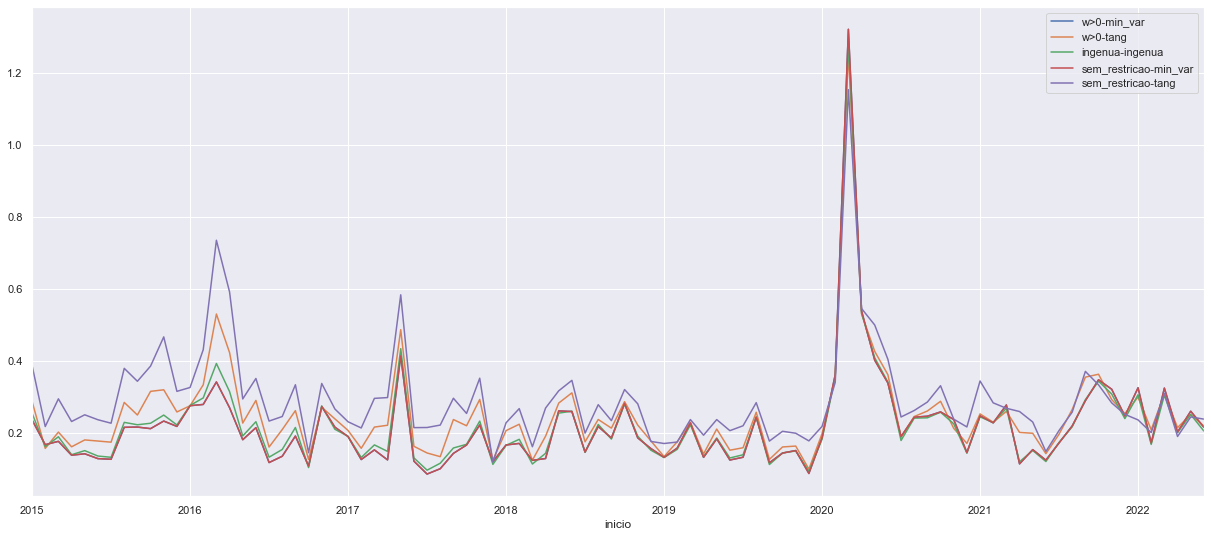

In [96]:
sns.set()
sim_volatilidade.plot(figsize=(21,9))

# Grafico Sharpe

<AxesSubplot:xlabel='inicio'>

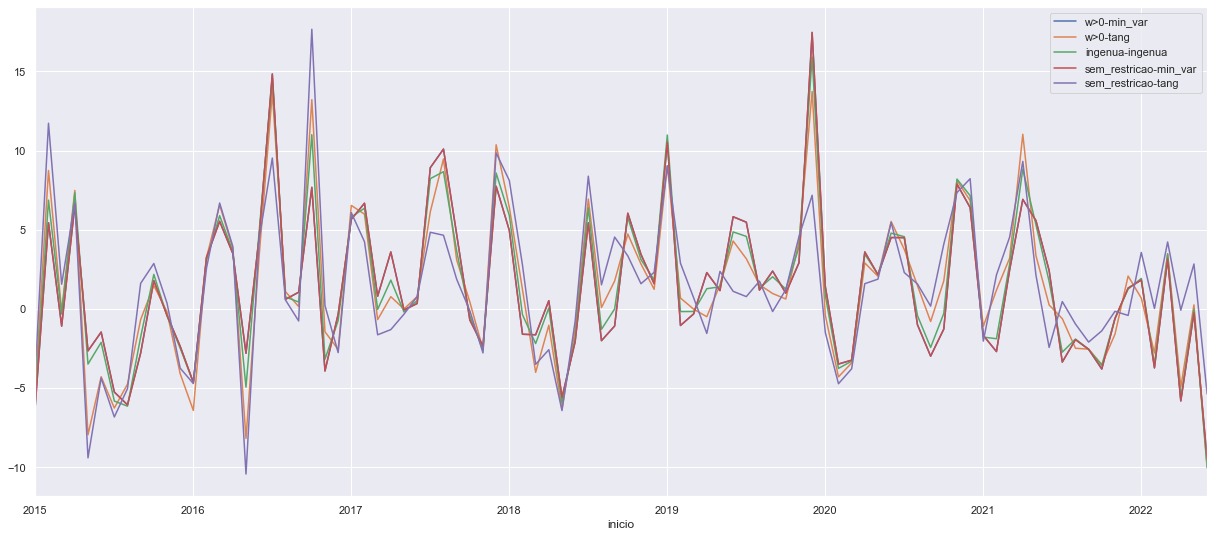

In [99]:
sns.set()
sim_stats_sharpe.plot(figsize=(21,9))

# Tabela Sharpe

In [100]:
sim_stats_sharpe

,w>0-min_var,w>0-tang,ingenua-ingenua,sem_restricao-min_var,sem_restricao-tang
inicio,,,,,
2015-01-01,-6.065925,-4.933891,-5.628179,-6.065925,-3.952207
2015-02-01,5.450833,8.746034,6.873117,5.450833,11.728354
2015-03-01,-1.077262,-0.137232,-0.319319,-1.077262,1.566667
2015-04-01,6.562984,7.488819,7.333527,6.562984,6.700779
2015-05-01,-2.640056,-7.933699,-3.472411,-2.640056,-9.392670
...,...,...,...,...,...
2022-02-01,-3.715165,-2.779375,-3.526203,-3.715165,0.035832
2022-03-01,3.163599,3.490884,3.471430,3.163599,4.234302
2022-04-01,-5.802169,-4.927533,-5.661731,-5.802169,-0.070642


# Periodo Fora da Amostra Carteira W>0 Tangencia

In [201]:
pd.DataFrame(simulacoes['w>0']['tang']['valor'])

,retorno_periodo,volatilidade,sharpe,inicio,fim,pesos_atuais,novos_pesos
0,-1.414820,0.286755,-4.933891,2015-01-01,2015-01-31,"[0.0, 0.0, 0.32527, 0.67473, 0.0]","[0.0, 0.0, 0.31112, 0.68888, 0.0]"
1,1.370151,0.156660,8.746034,2015-02-01,2015-02-28,"[0.0, 0.0, 0.31112, 0.68888, 0.0]","[0.0, 0.0, 0.35106, 0.64894, 0.0]"
2,-0.027711,0.201931,-0.137232,2015-03-01,2015-03-31,"[0.0, 0.0, 0.35106, 0.64894, 0.0]","[0.0, 0.0, 0.31775, 0.68225, 0.0]"
3,1.206488,0.161105,7.488819,2015-04-01,2015-04-30,"[0.0, 0.0, 0.31775, 0.68225, 0.0]","[0.0, 0.0, 0.31779, 0.68221, 0.0]"
4,-1.429566,0.180189,-7.933699,2015-05-01,2015-05-31,"[0.0, 0.0, 0.31779, 0.68221, 0.0]","[0.0, 0.0, 0.32098, 0.67902, 0.0]"
...,...,...,...,...,...,...,...
85,-0.579183,0.208386,-2.779375,2022-02-01,2022-02-28,"[0.0, 0.11907, 0.12676, 0.75417, 0.0]","[0.0, 0.14739, 0.10867, 0.74394, 0.0]"
86,1.075835,0.308184,3.490884,2022-03-01,2022-03-31,"[0.0, 0.14739, 0.10867, 0.74394, 0.0]","[0.0, 0.15348, 0.11889, 0.72763, 0.0]"
87,-1.056352,0.214377,-4.927533,2022-04-01,2022-04-30,"[0.0, 0.15348, 0.11889, 0.72763, 0.0]","[0.0, 0.21547, 0.07758, 0.70694, 0.0]"
88,0.065787,0.250686,0.262430,2022-05-01,2022-05-31,"[0.0, 0.21547, 0.07758, 0.70694, 0.0]","[0.0, 0.21919, 0.08825, 0.69256, 0.0]"


# Periodo de Fora da Amostra para a Carteira Ingenua 1/N

In [200]:
pd.DataFrame(simulacoes['ingenua']['ingenua']['valor'])

,retorno_periodo,volatilidade,sharpe,inicio,fim,pesos_atuais,novos_pesos
0,-1.430314,0.254134,-5.628179,2015-01-01,2015-01-31,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
1,1.110346,0.161549,6.873117,2015-02-01,2015-02-28,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
2,-0.060331,0.188938,-0.319319,2015-03-01,2015-03-31,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
3,1.020576,0.139166,7.333527,2015-04-01,2015-04-30,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
4,-0.522443,0.150455,-3.472411,2015-05-01,2015-05-31,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
...,...,...,...,...,...,...,...
85,-0.591358,0.167704,-3.526203,2022-02-01,2022-02-28,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
86,1.057276,0.304565,3.471430,2022-03-01,2022-03-31,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
87,-1.134426,0.200367,-5.661731,2022-04-01,2022-04-30,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"
88,-0.006881,0.250726,-0.027445,2022-05-01,2022-05-31,"[0.2, 0.2, 0.2, 0.2, 0.2]","[0.2, 0.2, 0.2, 0.2, 0.2]"


# Periodo Fora da Amostra para a Carteira de tangência sem restrição

In [199]:
pd.DataFrame(simulacoes['sem_restricao']['tang']['valor'])

,retorno_periodo,volatilidade,sharpe,inicio,fim,pesos_atuais,novos_pesos
0,-1.528122,0.386650,-3.952207,2015-01-01,2015-01-31,"[-1.0, 0.24759, 0.68657, 1.0, 0.06584]","[-1.0, 0.26055, 0.70104, 1.0, 0.03841]"
1,2.549180,0.217352,11.728354,2015-02-01,2015-02-28,"[-1.0, 0.26055, 0.70104, 1.0, 0.03841]","[-1.0, 0.25548, 0.73512, 1.0, 0.00939]"
2,0.460954,0.294226,1.566667,2015-03-01,2015-03-31,"[-1.0, 0.25548, 0.73512, 1.0, 0.00939]","[-1.0, 0.27321, 0.67568, 1.0, 0.05111]"
3,1.549730,0.231276,6.700779,2015-04-01,2015-04-30,"[-1.0, 0.27321, 0.67568, 1.0, 0.05111]","[-1.0, 0.31956, 0.67709, 1.0, 0.00335]"
4,-2.347348,0.249913,-9.392670,2015-05-01,2015-05-31,"[-1.0, 0.31956, 0.67709, 1.0, 0.00335]","[-1.0, 0.37534, 0.61525, 0.99291, 0.01649]"
...,...,...,...,...,...,...,...
85,0.007190,0.200646,0.035832,2022-02-01,2022-02-28,"[-1.0, 0.62373, 0.49884, 1.0, -0.12257]","[-1.0, 0.65825, 0.48491, 1.0, -0.14316]"
86,1.310014,0.309381,4.234302,2022-03-01,2022-03-31,"[-1.0, 0.65825, 0.48491, 1.0, -0.14316]","[-1.0, 0.64846, 0.48758, 1.0, -0.13604]"
87,-0.013405,0.189752,-0.070642,2022-04-01,2022-04-30,"[-1.0, 0.64846, 0.48758, 1.0, -0.13604]","[-1.0, 0.73487, 0.46423, 1.0, -0.19911]"
88,0.693912,0.243978,2.844155,2022-05-01,2022-05-31,"[-1.0, 0.73487, 0.46423, 1.0, -0.19911]","[-1.0, 0.74816, 0.48452, 1.0, -0.23267]"
